N= 2, τ=0.010, Erg / <EB> =0.999700
N= 4, τ=0.010, Erg / <EB> =0.999500
N= 6, τ=0.010, Erg / <EB> =0.999300
N= 8, τ=0.010, Erg / <EB> =0.999099
N=10, τ=0.010, Erg / <EB> =0.998899
N=12, τ=0.010, Erg / <EB> =0.998698
N=14, τ=0.010, Erg / <EB> =0.998498
N=16, τ=0.010, Erg / <EB> =0.998297
N=18, τ=0.010, Erg / <EB> =0.998118


/opt/anaconda3/lib/python3.13/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


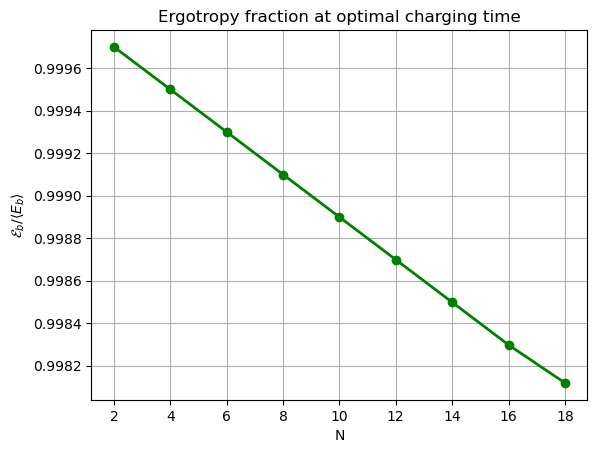

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# ---------------- parameters ----------------
N_arr = np.arange(2, 20, 2)
nmax = 20
ω = 1.0
ω0 = 1.0
g = 1.0
tlist = np.arange(0.01, 2*np.pi, 0.1)

# ---------------- operators ----------------
def collective_ops(N):
    Sp = qt.jmat(N/2, '+')
    Sm = Sp.dag()
    Sz = qt.jmat(N/2, 'z')
    HB = Sz + (N/2)*qt.qeye(N+1)
    return Sp, Sm, HB

def tavis_cummings(N, nmax, ω, ω0, g):
    a = qt.destroy(nmax)
    Sp, Sm, HB = collective_ops(N)
    H = (ω * qt.tensor(a.dag()*a, qt.qeye(N+1)) + ω0 * qt.tensor(qt.qeye(nmax), HB) + g * (qt.tensor(a, Sp) + qt.tensor(a.dag(), Sm)))
    return H, HB

def passive_state(rho, H):
    p = np.sort(rho.eigenenergies())[::-1]
    _, evecs = H.eigenstates()
    return sum(p[i] * evecs[i] * evecs[i].dag() for i in range(len(p)))

def initial_state(N, nmax, state):
    if state=="coherent":
        psiA = qt.coherent(nmax, np.sqrt(N))
    elif state=="fock":
        psiA = qt.basis(nmax, N)
    psiB = qt.basis(N+1, 0)  
    return qt.tensor(psiA, psiB)

# -------------------------------------------------
# Find optimal charging time τ (max power)
# -------------------------------------------------
τ_list = []

for N in N_arr:
    H, HB = tavis_cummings(N, nmax, ω, ω0, g)
    HB_full = qt.tensor(qt.qeye(nmax), HB)
    psi0 = initial_state(N, nmax, "fock")

    res = qt.sesolve(H, psi0, tlist, e_ops=HB_full)
    EB = np.array(res.expect[0])
    power = EB / tlist

    τ_list.append(tlist[np.argmax(power)])

# -------------------------------------------------
# Ergotropy and fluctuations
# -------------------------------------------------
E_ratio, F_ratio = [], []
opts = qt.Options(nsteps=10000)

for i, N in enumerate(N_arr):

    τ = τ_list[i]
    H, HB = tavis_cummings(N, nmax, ω, ω0, g)
    psi0 = initial_state(N, nmax, "fock")

    res = qt.sesolve(H, psi0, [0, τ], options=opts)
    rho_b = res.states[-1].proj().ptrace(1)

    rho_p = passive_state(rho_b, HB)

    E_B = qt.expect(HB, rho_b)
    E_op = HB - qt.expect(HB, rho_p) * qt.qeye(HB.dims[0])

    E_erg = qt.expect(E_op, rho_b)
    ΔE = np.sqrt(qt.expect(E_op**2, rho_b) - E_erg**2)

    E_ratio.append(E_erg / E_B)
    F_ratio.append(ΔE / E_erg)

for idx, N in enumerate(N_arr):
    print(f"N={N:2d}, τ={τ_list[idx]:.3f}, Erg / <EB> ={E_ratio[idx]:.6f}")


# -------------------------------------------------
# Plots
# -------------------------------------------------
plt.plot(N_arr, E_ratio, 'o-', color='g', linewidth=2)
plt.xlabel("N")
plt.ylabel(r"$\mathcal{E}_b / \langle E_b \rangle$")
plt.title("Ergotropy fraction at optimal charging time")
plt.grid(True)
plt.show()

N= 2, τ=0.010, Relative Fluctuation =0.012253
N= 4, τ=0.010, Relative Fluctuation =0.011190
N= 6, τ=0.010, Relative Fluctuation =0.010815
N= 8, τ=0.010, Relative Fluctuation =0.010624
N=10, τ=0.010, Relative Fluctuation =0.010510
N=12, τ=0.010, Relative Fluctuation =0.010434
N=14, τ=0.010, Relative Fluctuation =0.010381
N=16, τ=0.010, Relative Fluctuation =0.010342
N=18, τ=0.010, Relative Fluctuation =0.010079


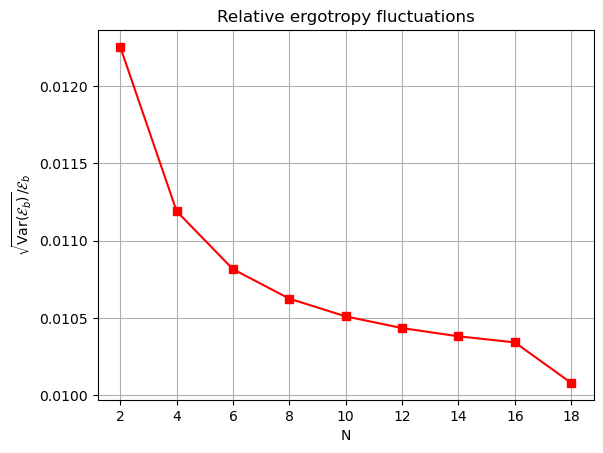

In [2]:
for idx, N in enumerate(N_arr):
    print(f"N={N:2d}, τ={τ_list[idx]:.3f}, Relative Fluctuation ={F_ratio[idx]:.6f}")


plt.plot(N_arr, F_ratio, 's-', color='r')
plt.xlabel("N")
plt.ylabel(r"$\sqrt{\mathrm{Var}(\mathcal{E}_b)}/\mathcal{E}_b$")
plt.title("Relative ergotropy fluctuations")
plt.grid(True)
plt.show()